### Overview

In this notebook, I would like to present a framework for **partitioned validation** using one-week hold out.  
As an example of possible groupings of customers, here I choose '**online vs. offline**', which shows that it is more difficult to predict future purchases of offline uses than to predict those of online users.  
  

## Parquet Format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

In [ ]:
adf = pd.read_parquet('/content/drive/MyDrive/Project_Data/Parquet/articles.parquet')
adf.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,10,0,0,1,0,16,30,1002,2,8834
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,10,0,0,1,0,16,30,1002,2,8834
2,108775051,108775,44846,253,9,0,1010017,3,11,11,...,10,0,0,1,0,16,30,1002,2,8834
3,110065001,110065,8159,306,13,4,1010016,0,9,0,...,131,7,7,1,0,61,5,1017,4,8243
4,110065002,110065,8159,306,13,4,1010016,0,10,2,...,131,7,7,1,0,61,5,1017,4,8243


In [ ]:
import pyspark

sc = pyspark.SparkContext('local[*]')
sqlContext = pyspark.sql.SQLContext(sc)
df = sqlContext.read.option("header", "true").option("inferSchema", "true").option("mode", "DROPMALFORMED").csv('/content/drive/MyDrive/Project_Data/transactions_train.csv')
df.write.parquet('/content/drive/MyDrive/Project_Data/transactions_train.parquet' )

### Libraries and Functions

In [ ]:
import numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
from collections import defaultdict

def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))

def apk(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def blend(dt, w=[], k=12):
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] < 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

def validation(actual, predicted, grouping, score=0, index=-1, ignore=False, figsize=(12, 6)):
    # actual, predicted : list of lists
    # group : pandas Series
    # score : pandas DataFrame
    if ignore: return
    ap12 = mapk(actual, predicted, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    if isinstance(score, int): score = pd.DataFrame({g:[] for g in sorted(grouping.unique().tolist())})
    if index == -1 : index = score.shape[0]
    score.loc[index, "All"] = map12
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1); sns.histplot(data=ap12, log_scale=(0, 10), bins=20); plt.title(f"MAP@12 : {map12}")
    for g in grouping.unique():
        map12 = round(mapk(actual[grouping == g], predicted[grouping == g]), 6)
        score.loc[index, g] = map12
    plt.subplot(1, 2, 2); score[[g for g in grouping.unique()[::-1]] + ['All']].loc[index].plot.barh(); plt.title(f"MAP@12 of Groups")
    vc = pd.Series(predicted).apply(len).value_counts()
    display(score)
    return score

### Data

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Project_Data/Parquet/transactions_train.parquet')
sub = pd.read_csv('/content/drive/MyDrive/Project_Data/sample_submission.csv')
cid = pd.DataFrame(sub.customer_id.apply(lambda s: int(s[-16:], 16)))

### Definition of Groups

In [ ]:
group = df.groupby('customer_id').sales_channel_id.mean().round().reset_index()\
    .merge(cid, on='customer_id', how='right').rename(columns={'sales_channel_id':'group'})
grouping = group.group.fillna(1.0)

### One-Week Hold Out

In [ ]:
val_week = 104
# id of week to be used in a validation; set 105 to create a submission
val = df.loc[df.week == val_week].groupby('customer_id').article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right')
actual = val.article_id.apply(lambda s: [] if pd.isna(s) else s.split())
last_date = df.loc[df.week < val_week].t_dat.max()

### Last Purchased Items

,1.0,2.0,All
Last Purchase,0.012807,0.024439,0.020594


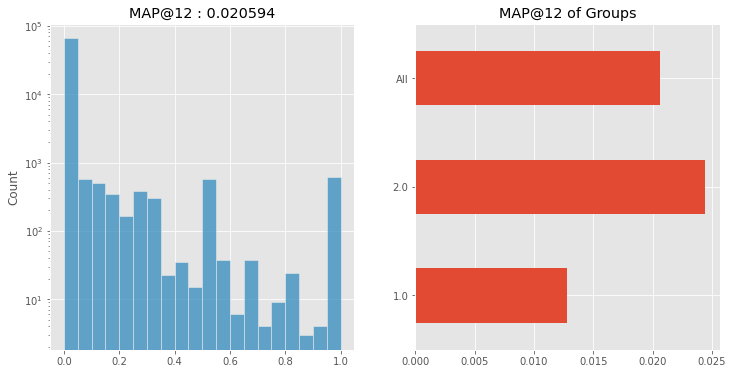

In [ ]:
init_date = last_date - dt.timedelta(days=9999)
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()
train = train.merge(train.groupby('customer_id').t_dat.max().reset_index().rename(columns={'t_dat':'l_dat'}),
                   on = 'customer_id', how='left')
train['d_dat'] = (train.l_dat - train.t_dat).dt.days
train = train.loc[train.d_dat < 14].sort_values(['t_dat'], ascending=False).drop_duplicates(['customer_id', 'article_id'])
sub['last_purchase'] = train.groupby('customer_id')\
    .article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right').article_id.fillna('')

predicted = sub['last_purchase'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, index='Last Purchase', ignore=(val_week == 105))

### Other Colors of Purchased Item

,1.0,2.0,All
Last Purchase,0.012807,0.024439,0.020594
Other Colors,0.005846,0.008675,0.007740


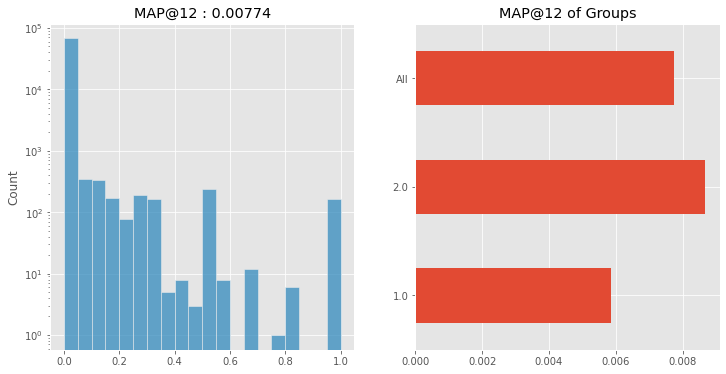

In [ ]:
init_date = last_date - dt.timedelta(days=6)
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .groupby(['article_id']).t_dat.count().reset_index()
adf = pd.read_parquet('/content/drive/MyDrive/Project_Data/Parquet/articles.parquet')
adf = adf.merge(train, on='article_id', how='left').rename(columns={'t_dat':'ct'})\
    .sort_values('ct', ascending=False).query('ct > 0')

map_to_col = defaultdict(list)
for aid in adf.article_id.tolist():
    map_to_col[aid] = list(filter(lambda x: x != aid, adf[adf.product_code == aid // 1000].article_id.tolist()))[:1]

def map_to_variation(s):
    f = lambda item: iter_to_str(map_to_col[int(item)])
    return ' '.join(map(f, s.split()))
sub['other_colors'] = sub['last_purchase'].fillna('').apply(map_to_variation)

predicted = sub['other_colors'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Other Colors', ignore=(val_week == 105))

### Popular Items for Each Group

,1.0,2.0,All
Last Purchase,0.012807,0.024439,0.020594
Other Colors,0.005846,0.008675,0.007740
Popular Items,0.009144,0.008807,0.008918


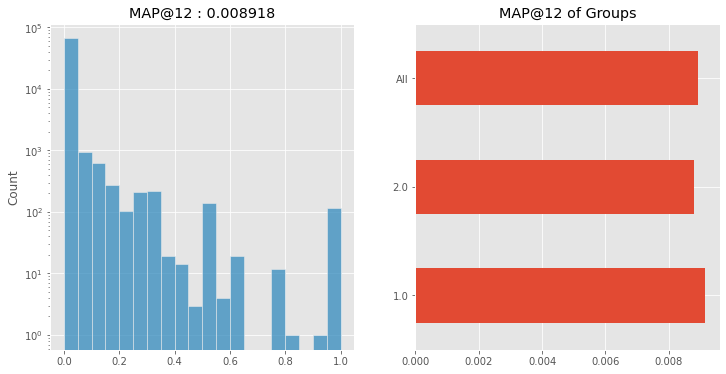

In [ ]:
init_date = last_date - dt.timedelta(days=5 - 1)
group_df = pd.concat([cid, group.group.fillna(1)], axis=1) # grouping can be changed
group_df.columns = ['customer_id', 'group']
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .merge(group_df, on='customer_id', how='left')\
    .groupby(['group', 'article_id']).t_dat.count().reset_index()
items = defaultdict(str)
for g in train.group.unique():
    items[g] = iter_to_str(train.loc[train.group == g].sort_values('t_dat', ascending=False).article_id.tolist()[:12])

sub['popular_items'] = group_df.group.map(items)

predicted = sub['popular_items'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Popular Items', ignore=(val_week == 105))

### Blend Predictions

In [ ]:
init_date = last_date - dt.timedelta(days=11)
sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())

,1.0,2.0,All
Last Purchase,0.012807,0.024439,0.020594
Other Colors,0.005846,0.008675,0.007740
Popular Items,0.009144,0.008807,0.008918
Prediction,0.018279,0.029840,0.026018


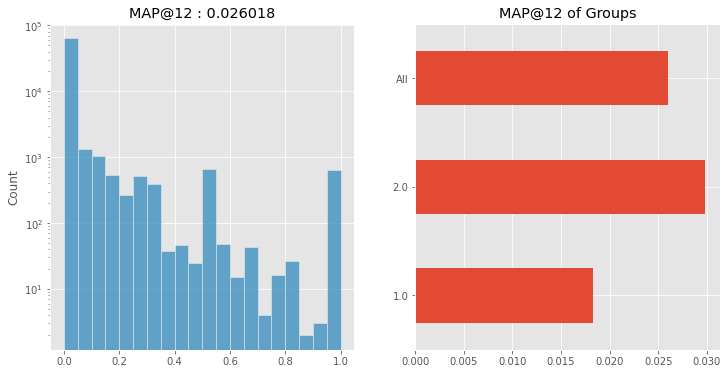

In [ ]:
sub['prediction'] = sub[['last_purchase', 'other_colors', 'popular_items']]\
.apply(blend, w=[100, 10, 1], axis=1, k=32).apply(prune, ok_set=sold_set)
predicted = sub.prediction.apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Prediction', ignore=(val_week == 105))

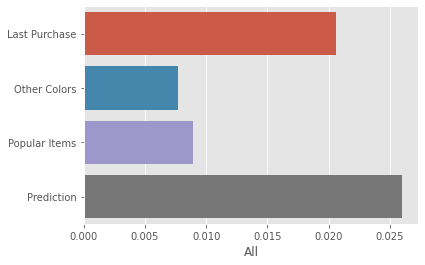

In [ ]:
sns.barplot(data=score, x='All', y=score.index)

In [ ]:
if val_week == 105: sub[['customer_id', 'prediction']]

In [ ]:
sub[['customer_id', 'prediction']].to_csv("sub_val.csv", index=False)


In [ ]:
import pandas as pd

a = pd.read_csv('sub_val.csv')
a.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0924243001 0865799006 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002 0924243001 0865799006 0909370001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0924243001 0865799006 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243001 0865799006 0909370001 0923758001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0791587015 0927530004 0730683050 0896152002 07...
